In [77]:
#Learn Code from 
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#Author: Jason Brownlee

#import library
import pandas as pd
import numpy as np
import math
import utils
from matplotlib import pyplot as plt

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [79]:
df_data_set = pd.read_csv('Data/shcmp multi variable.csv')
df_data_set.set_index('Date',inplace=True)
df_data_set.head(5)
len(df_data_set)

4410

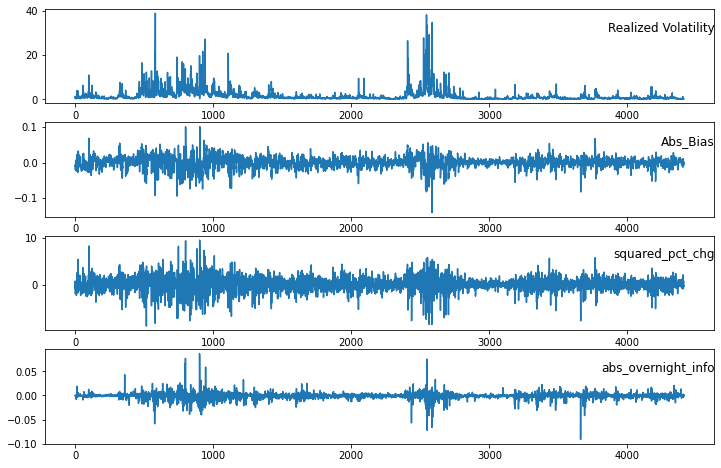

In [80]:
# plot each column
Variables = df_data_set.columns
plt.figure(figsize=(12,8))
for group in range(len(Variables)):
 plt.subplot(len(Variables), 1, group+1)
 plt.plot(df_data_set.values[:, group])
 plt.title(df_data_set.columns[group], y=0.7, loc='right')
plt.show()

In [81]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [82]:
#Set Windows size here
WINDOWS_SIZE = 20
X,y = df_to_X_y3(df_data_set, window_size = WINDOWS_SIZE)

X.shape,y.shape

((4390, 20, 4), (4390,))

In [83]:
#Convert the data into training set, validation set and test set
#The number percentage of each set is 80%, 10% and 10%

#OR CUSTOMIZE YOUR PERCENTAGE OF EACH SET HERE
TRAINING_DATA_LEN = math.ceil(len(X)*0.8)
VALIDATION_LEN = math.ceil(len(X)*0.9)

X_train, y_train, X_val, y_val, X_test, y_test = utils.split_to_training_val_test(X,y,\
    training_len=TRAINING_DATA_LEN, val_len=VALIDATION_LEN)

#check size of each set
X_train.shape, X_test.shape, X_val.shape,y_test.shape,y_train.shape,y_test.shape

((3512, 20, 4), (439, 20, 4), (439, 20, 4), (439,), (3512,), (439,))

In [87]:
#built model_multi for multi variate LSTM
model_multi = Sequential()
model_multi.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_multi.add(LSTM(64, dropout=0.2))
model_multi.add(Dense(1, 'linear'))

model_multi.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [88]:
cp = ModelCheckpoint('model_multi/', save_best_only=True)
model_multi.compile(loss=MeanSquaredError(), \
              optimizer=Adam(learning_rate=0.005), metrics=[RootMeanSquaredError()])

In [89]:
#Set Epoch here
EPOCH = 30

#Start to train model
history = model_multi.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCH, callbacks=[cp])

Epoch 1/30
110/110 [==============================] - 3s 14ms/step - loss: 4.9516 - root_mean_squared_error: 2.2252 - val_loss: 0.2723 - val_root_mean_squared_error: 0.5218


INFO:tensorflow:Assets written to: model_multi\assets


INFO:tensorflow:Assets written to: model_multi\assets


Epoch 2/30
110/110 [==============================] - 1s 13ms/step - loss: 4.3396 - root_mean_squared_error: 2.0832 - val_loss: 0.4486 - val_root_mean_squared_error: 0.6698
Epoch 3/30
110/110 [==============================] - 1s 12ms/step - loss: 4.0825 - root_mean_squared_error: 2.0205 - val_loss: 0.3323 - val_root_mean_squared_error: 0.5764
Epoch 4/30
110/110 [==============================] - 1s 11ms/step - loss: 3.9528 - root_mean_squared_error: 1.9882 - val_loss: 0.4577 - val_root_mean_squared_error: 0.6766
Epoch 5/30
110/110 [==============================] - 1s 11ms/step - loss: 3.7696 - root_mean_squared_error: 1.9416 - val_loss: 0.3574 - val_root_mean_squared_error: 0.5978
Epoch 6/30
110/110 [==============================] - 1s 12ms/step - loss: 3.7717 - root_mean_squared_error: 1.9421 - val_loss: 0.3927 - val_root_mean_squared_error: 0.6266
Epoch 7/30
110/110 [==============================] - 1s 11ms/step - loss: 3.8377 - root_mean_squared_error: 1.9590 - val_loss: 0.3650 

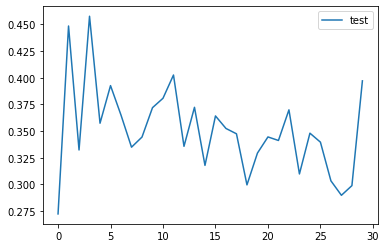

In [90]:
# plot history
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [91]:
from tensorflow.keras.models import load_model
#check result for training set
model1 = load_model('model_multi/')
train_predictions = model1.predict(X_test).flatten()

In [92]:
train_results = pd.read_csv('Data/date.csv')
train_results['Date'] = pd.to_datetime(train_results['Date'])
train_results.set_index('Date',inplace=True)

train_results['Train Predictions'] = train_predictions

In [93]:
train_results.head(5)

,Realized Volatility,Train Predictions
Date,,
2021-05-11,0.794308,0.471714
2021-05-12,0.480160,0.467362
2021-05-13,0.647137,0.410244
2021-05-14,0.489060,0.641325
2021-05-17,0.423597,0.371439


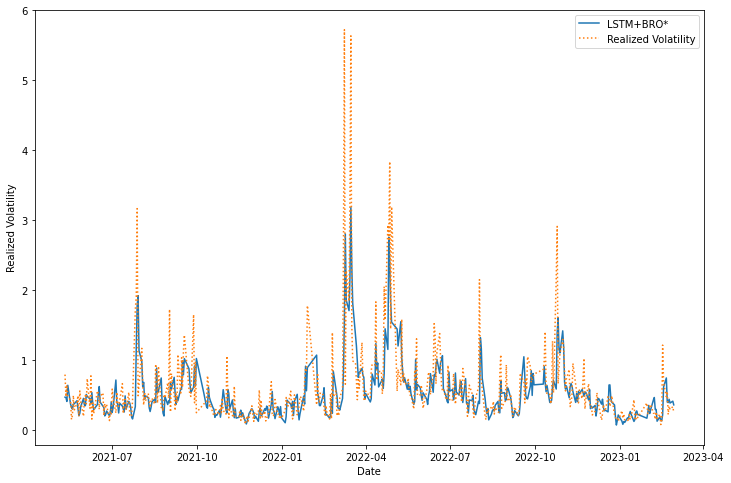

In [96]:
plt.figure(figsize=(12,8))
plt.plot(train_results['Train Predictions'], label='LSTM+BRO*')
plt.plot(train_results['Realized Volatility'], label='Realized Volatility',linestyle=':')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()

In [95]:
#show error
Predictions_val = train_results['Train Predictions']
Actual_val = train_results['Realized Volatility']

utils.Predictions_Error(Predictions_val,Actual_val)

MAE =  0.2496582664081693
MSE =  0.20213186345142015
RMSE =  0.4495907733166019
R_2 =  0.45552448270570156
RMSPE =  0.6009326946371549
MSLE =  0.038816917007871
